In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 불러오기 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# # datetime 컬럼을 datetime 타입으로 변환
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# datetime에서 유용한 특성 추출
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

#데이터 전처리

train['temp_group'] = pd.cut(train['temp'], bins=np.arange(0, train['temp'].max() + 5, 5), right=False)
test['temp_group'] = pd.cut(test['temp'], bins=np.arange(0, test['temp'].max() + 5, 5), right=False)

# 2. temp_group을 원-핫 인코딩하여 범주형 변수를 수치형 변수로 변환
train = pd.get_dummies(train, columns=['temp_group'])
test = pd.get_dummies(test, columns=['temp_group'])

# 3. 생성된 temp_group 컬럼들의 이름을 'temp'로 변경
train.columns = [col if not col.startswith('temp_group_') else 'temp' for col in train.columns]
test.columns = [col if not col.startswith('temp_group_') else 'temp' for col in test.columns]


#범주형 데이터 처리 원-핫 인코딩
train = pd.get_dummies(train, columns=['season', 'weather'])
features = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'hour']
encoded_columns = [col for col in train.columns if 'season_' in col or 'weather_' in col]

features += encoded_columns


import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
   # 필요 컬럼이 존재하는지 확인 후 원-핫 인코딩
    if 'season' in data.columns and 'weather' in data.columns:
        data = pd.get_dummies(data, columns=['season', 'weather'])
    
    # 풍속이 0인 데이터와 0이 아닌 데이터를 나눕니다
    wind0 = data.loc[data['windspeed'] == 0]
    windnot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속 예측을 위해 사용할 컬럼 (날짜에서 요일을 추출한 'day'가 없다면 제거)
    col = [c for c in ['season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'temp', 'humidity', 'atemp'] if c in data.columns]
    windnot0['windspeed'] = windnot0['windspeed'].astype('str')
    
    # RandomForest 모델 초기화
    rf = RandomForestClassifier()
    
    # 풍속이 0이 아닌 데이터로 모델 학습
    rf.fit(windnot0[col], windnot0['windspeed'])
    
    # 풍속이 0인 부분을 예측
    pred_wind0 = rf.predict(wind0[col])
    
    # 예측된 값을 wind0 데이터의 'windspeed'에 대입
    wind0['windspeed'] = pred_wind0
    
    # 두 데이터프레임을 합치고, windspeed를 float 타입으로 변환
    data = pd.concat([windnot0, wind0])
    data['windspeed'] = data['windspeed'].astype('float')
    
    # 인덱스 리셋
    data.reset_index(drop=True, inplace=True)
    
    return data

# 풍속 예측을 포함하여 train과 test 데이터 처리
train = predict_windspeed(train)
test = predict_windspeed(test)

#사용할 특성 선택
features = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'year', 'month', 'hour', 'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4']

# X는 자전거 수요에 필요한 변측값, Y는 자전거 사용자의 총 수요 수 (정답)
X = train[features]
y = train['count']


# 학습/검증 데이터 분리  # train 중 20% 를 validation data로 사용  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 


# 모델 생성
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],))) # 첫 번째 은닉층
model.add(Dropout(0.2))  # 과적합 방지를 위한 드롭아웃
model.add(Dense(64, activation='relu')) # 두 번째 은닉층
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu')) # 세 번째 은닉층
model.add(Dropout(0.2))
model.add(Dense(1)) # 출력층 (회귀 문제이므로 활성화 함수 없음)


# 모델 컴파일

model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae'])


# 모델 훈련
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)


C:\Users\kjins\AppData\Local\Temp\ipykernel_29200\1565931671.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windnot0['windspeed'] = windnot0['windspeed'].astype('str')
C:\Users\kjins\AppData\Local\Temp\ipykernel_29200\1565931671.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind0['windspeed'] = pred_wind0
C:\Users\kjins\AppData\Local\Temp\ipykernel_29200\1565931671.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Epoch 1/50


c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 43618.4492 - mae: 160.6781 - val_loss: 35601.6797 - val_mae: 138.4302
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 34318.2461 - mae: 143.0923 - val_loss: 31039.4824 - val_mae: 138.4179
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 34109.3359 - mae: 141.8306 - val_loss: 27523.9980 - val_mae: 124.4303
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 27909.9668 - mae: 127.9176 - val_loss: 22742.8887 - val_mae: 108.3560
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 25848.7129 - mae: 119.3910 - val_loss: 24516.0293 - val_mae: 103.0710
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 24279.6406 - mae: 113.1728 - val_loss: 22749.1289 - val_mae: 101.3019
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 23843.1074 - mae: 111.1782 - val_loss: 21539.0586 - val_mae: 109.2159
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 23629.1289 - mae: 112.0135 

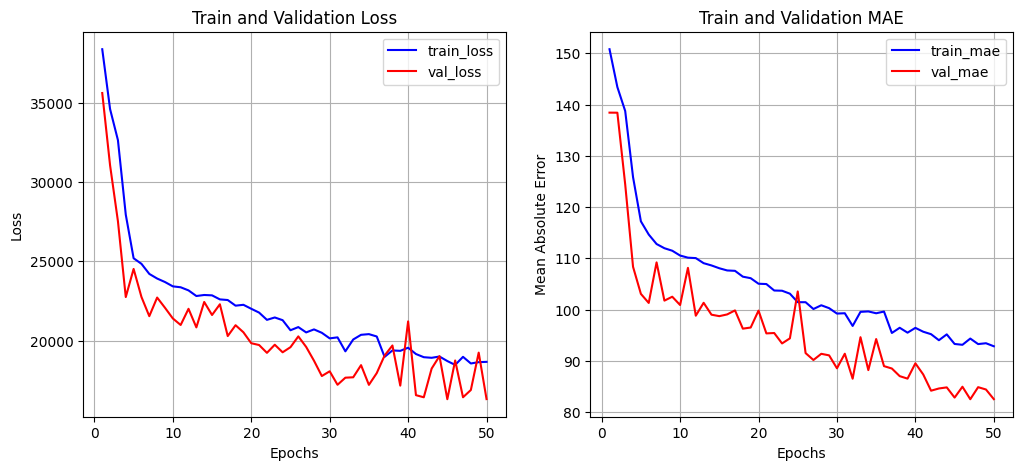

In [2]:

# 기록을 눈으로 보기 편하게 시각화
# history 객체에서 학습 기록을 딕셔너리 형태로 가져옴
# history.history에는 loss, accuracy 등의 지표가 epoch별로 저장되어 있음
import matplotlib.pyplot as plt

history_dict = history.history

# 학습 손실(loss)과 검증 손실(validation loss) 데이터 추출
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# 시각화를 위한 x축 데이터(epochs) 생성. 1부터 시작하여 loss 데이터 길이만큼의 범위 생성
epochs = range(1, len(loss)+1)

# 그래프를 그리기 위한 figure 생성
# figsize로 그래프 크기 지정 (가로 12, 세로 5)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1) # 행 / 열 / 위치
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')

ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

# 학습 정확도(accuracy)와 검증 정확도(validation accuracy) 데이터 추출
mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, color='blue', label='train_mae')
ax2.plot(epochs, val_mae, color='red', label='val_mae')

ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Absolute Error')
ax2.grid()
ax2.legend()

plt.show()

In [3]:
# 검증 데이터로 평가
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 16495.8887 - mae: 83.4539


In [ ]:
# test 데이터의 피처
X_test = test[features]

# Sequential 모델로 예측
test_pred = model.predict(X_test)


In [ ]:
# 제출 파일 생성
submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': test_pred.flatten()  # 예측 결과를 1차원으로 변환
})
submission.to_csv('submission(git).csv', index=False)
print('제출 파일이 생성되었습니다.')